# Results without SpaGE imputation for missing genes

One concern when using SpaGE imputation for applying the clocks on datasets with different gene panels is that the resulting prediction could be influenced more by the training dataset than biological signal in the target dataset. This notebook contains code for generating the main results from `3E_clocks_external_validation.ipynb` and `4A_application_to_interventions.ipynb` without SpaGE imputation (using instead mean imputation which will only shift the intercept for predicted ages and thus all variability will depend on biological signal in the target dataset).

**Inputs required:**
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock.py`)
- assorted AnnData objects corresponding to external datasets from Allen et al. (2022) and Ximerakis et al. (2019) and reformatted according to steps in Methods section of manuscript 
- assorted AnnData objects corresponding to external datasets from Allen et al. (2022), Zeng et al. (2023), Androvic et al. (2023), Kukanja et al. (2024) and reformatted according to steps in Methods section of manuscript 

**Conda environment used**: `requirements/merfish.txt`


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp
from decimal import Decimal

from clock_preprocessing import *
from clock_prediction import *

In [2]:
# CUSTOM Pink-Green colormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

# create colormap
# ---------------

# number of shades to cut in
cut_in = round(0.04*256)

# set side colormaps
upper = matplotlib.cm.PiYG_r(np.arange(256))

# create middle colormap
lower1 = np.ones((int(256/4),4))
lower2 = np.ones((int(256/4),4))
ulen = round(upper.shape[0]/2)
for i in range(3):
    lower1[:,i] = np.linspace(1, upper[ulen-cut_in,i], lower1.shape[0])
    lower2[:,i] = np.linspace(1, upper[ulen+cut_in,i], lower2.shape[0])

# combine parts of colormap
cmap = np.vstack((upper[:ulen-cut_in,:], lower1[::-1], lower2, upper[ulen+cut_in:,:]))

# convert to matplotlib colormap
cmap = matplotlib.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

In [3]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltype_palette = {'Neuron-Excitatory':'forestgreen',
                    'Neuron-Inhibitory':'lightgreen', 
                    'Neuron-MSN':'yellowgreen',
                    'Astrocyte': 'royalblue', 
                    'Microglia': 'aqua', 
                    'Oligodendrocyte': 'skyblue', 
                    'OPC': 'deepskyblue',
                    'Endothelial': 'red', 
                    'Pericyte': 'darkred', 
                    'VSMC': 'salmon', 
                    'VLMC': 'indianred',
                    'Ependymal': 'gray', 
                    'Neuroblast': 'sandybrown', 
                    'NSC':'darkorange', 
                    'Macrophage':'purple', 
                    'Neutrophil':'darkviolet',
                    'T cell':'magenta', 
                    'B cell':'orchid',
}

# function for bootstrap sampling for statistics
def bootstrap_median_difference (df1, df2, ci=0.95, num_boot=1000):
    '''
    Given two dataframes with mouse_id and pred_age as columns, computes bootstrap confidence interval.
    Bootstrap samples by mouse_id within each dataframe separately.
    Computes difference of medians df1-df2.
    Computes confidence interval for these differences.
    '''
    med_diffs = []
    for i in range(num_boot):
        
        boot_df1_stacks = []
        draw1 = np.random.choice(np.unique(df1["mouse_id"].values), len(np.unique(df1["mouse_id"].values)), replace=True)
        for d1 in draw1:
            boot_df1_stacks.append(df1[df1["mouse_id"]==d1].copy())
        
        boot_df2_stacks = []
        draw2 = np.random.choice(np.unique(df2["mouse_id"].values), len(np.unique(df2["mouse_id"].values)), replace=True)
        for d2 in draw2:
            boot_df2_stacks.append(df2[df2["mouse_id"]==d2].copy())
        
        boot_df1 = pd.concat(boot_df1_stacks)
        boot_df2 = pd.concat(boot_df2_stacks)
        med_diffs.append(boot_df1["pred_age"].median() - boot_df2["pred_age"].median())
    
    # confidence interval
    lower = np.quantile(med_diffs, 0.025)
    upper = np.quantile(med_diffs, 0.975)
    
    return((lower,upper))

## Mean Imputation (instead of SpaGE)

### Allen et al. (2022)

In [4]:
adata = sc.read_h5ad("data/allen_2022_aging_merfish/merfish_combined_processed_umap.h5ad")
adata.obs["region"] = adata.obs.tissue.copy()

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, normalize=False, standardize=False, fill_missing="mean")

Astrocyte
Imputing values for 225 missing genes
Endothelial
Imputing values for 225 missing genes
Macrophage
Imputing values for 225 missing genes
Microglia
Imputing values for 225 missing genes
Neuron-Excitatory
Imputing values for 225 missing genes
Neuron-Inhibitory
Imputing values for 225 missing genes
Neuron-MSN
Imputing values for 225 missing genes
OPC
Imputing values for 225 missing genes
Oligodendrocyte
Imputing values for 225 missing genes
Pericyte
Imputing values for 225 missing genes
T cell
Imputing values for 225 missing genes
VLMC
Imputing values for 225 missing genes


In [6]:
# df.to_csv(f"results/clocks/applied/allen_aging_lps_spatialsmooth_mean.csv")
# adata.write_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_mean.h5ad")

In [4]:
df = pd.read_csv(f"results/clocks/applied/allen_aging_lps_spatialsmooth_mean.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

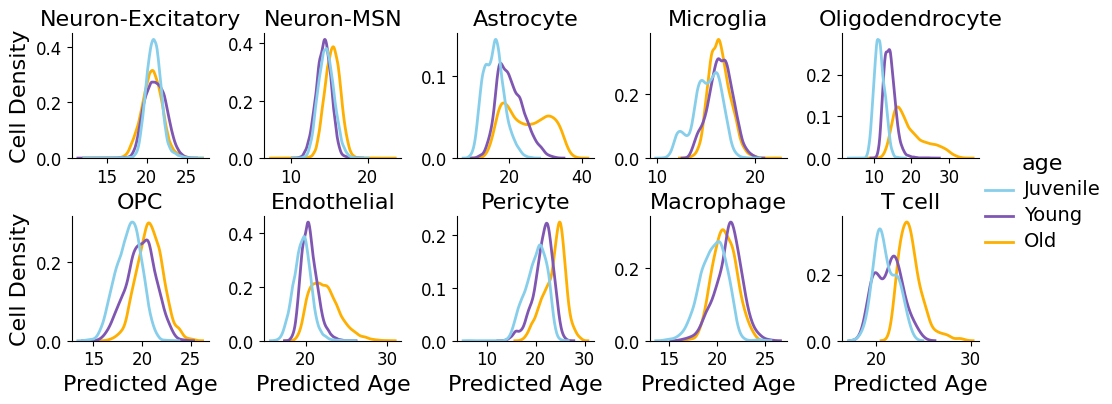

In [10]:
df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

palette = {"Young":"#7F57B2",
           "Juvenile":"#87CEEB",
           "Old":"#FEAF00"}

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=10/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Juvenile", "Young", "Old"], linewidth=2, common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/allen_aging_spatialsmooth_mean.pdf", bbox_inches='tight')
plt.show()

In [5]:
df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)
df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

# compute stats

celltypes = ["Neuron-Excitatory", "Neuron-MSN", "Astrocyte", "Microglia",
             "Oligodendrocyte", "OPC", "Endothelial", "Pericyte",
             "Macrophage", "T cell"]
comparisons = [["Old", "Juvenile"],
               ["Old", "Young"],
               ["Young", "Juvenile"]]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_aging[df_aging["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
-0.201
-0.403
0.202
0.865
1.14
-0.277
8.63
4.55
4.09
1.13
-0.159
1.29
7.03
4.42
2.62
2.07
0.846
1.23
2.51
1.76
0.75
3.94
2.44
1.5
1.08
-0.549
1.63
2.76
1.92
0.837

DIFF LOWER:
-0.587
-1.41
-0.431
0.434
0.829
-0.699
5.62
1.05
2.1
0.508
-0.746
0.55
5.91
3.34
1.88
1.62
0.0454
0.275
1.66
0.719
0.438
2.42
1.1
0.178
0.317
-1.21
0.698
1.29
1.24
-1.64

DIFF UPPER:
0.218
0.299
1.13
1.23
1.46
0.101
11.9
7.74
6.67
1.98
0.378
2.23
8.27
5.67
3.28
2.54
1.85
2.05
3.3
2.61
1.11
5.15
3.61
2.75
1.92
0.449
2.51
3.81
3.9
1.66


/local/scratch/edsun/slrmtmp.42835274/ipykernel_88550/3222507901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


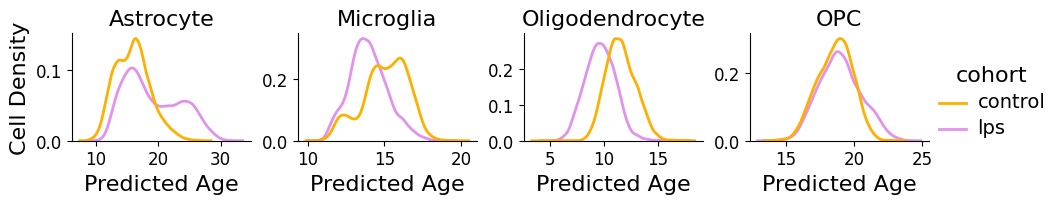

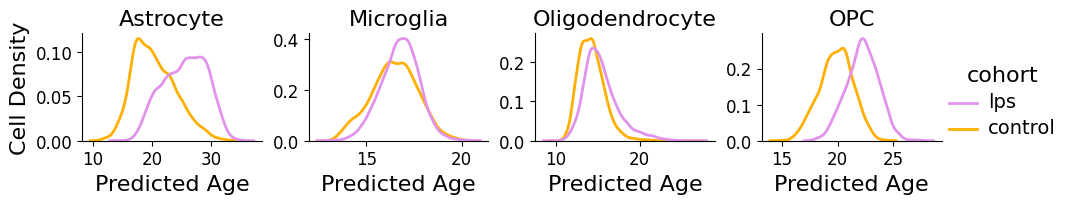

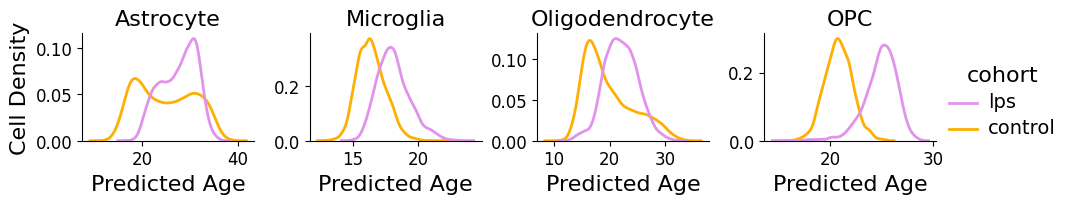

In [10]:
# TOP 4 SUBSET

sub_df = df[df["celltype"].isin(["Astrocyte","Microglia","Oligodendrocyte","OPC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

for age in np.unique(sub_df['age']):
    df_lps = sub_df[sub_df['age']==age].copy()
    df_lps = df_lps.replace('aging', 'control')

    palette = {"control":"#FEAF00",
           "lps":"#E193EC"} # #E193EC

    ncols = 4
    g = sns.displot(data=df_lps[df_lps['age']==age], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                linewidth=2, common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.savefig(f"plots/clocks/allen_lps{round(float(age))}_spatialsmooth_mean_SUBSET.pdf")
    plt.show()

In [6]:
# compute stats

df_lps = df[df['age']==20.93]

celltypes = ["Astrocyte","Microglia","Oligodendrocyte","OPC"]
comparisons = [["lps", "aging"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_lps[df_lps["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
3.74
1.66
3.39
4.31

DIFF LOWER:
0.964
1.06
1.75
3.54

DIFF UPPER:
6.88
2.42
4.91
4.96


/local/scratch/edsun/slrmtmp.42835274/ipykernel_88550/3796906198.py:50: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


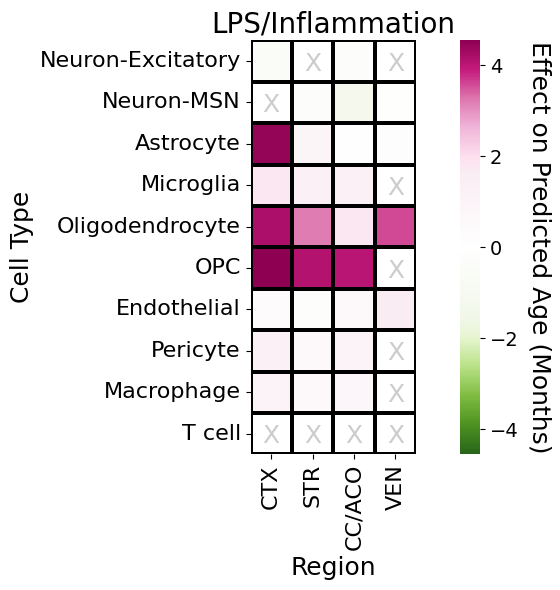

In [11]:
# OLD region-specific intervention effect


coarse_region_mapping = {
    "corpus callosum":"CC/ACO",
    "olfactory region":"CC/ACO",
    "cortical layer II/III":"CTX",
    "cortical layer V":"CTX",
    "cortical layer VI":"CTX",
    "pia mater":"CTX",
    "striatum":"STR",
    "brain ventricle":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]
df['age'] = df['age'].astype(str)
df['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df['age']]


# fingerprint heatmap
effect_cutoff = 0


region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region_coarse"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)&(df['age']=='Old')].copy()
        sub_df = sub_df.replace('aging', 'control')
        if sub_df[sub_df['cohort']=="lps"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="lps"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("LPS/Inflammation", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/clocks/allen_spatialsmooth_heatmap_medians_REGIONED_Old_meanimputed.pdf",
            bbox_inches='tight')
plt.show()

### Zeng et al. (2023)

In [12]:
adata = sc.read_h5ad("data/zeng_2023_alzheimer_starmap/starmap_AD_processed.h5ad")
adata.obsm['spatial'] = adata.obs[["X","Y"]].values
adata.obs["region"] = adata.obs.region_merged.copy()

In [13]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="mean")

Astrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Endothelial


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 128 missing genes


In [14]:
# df.to_csv(f"results/clocks/applied/zeng_starmapAD_spatialsmooth_mean.csv")
# adata.write_h5ad("results/clocks/anndata/zeng_starmapAD_spatialsmooth_mean.h5ad")

In [7]:
df = pd.read_csv(f"results/clocks/applied/zeng_starmapAD_spatialsmooth_mean.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.42835274/ipykernel_88550/1150148726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


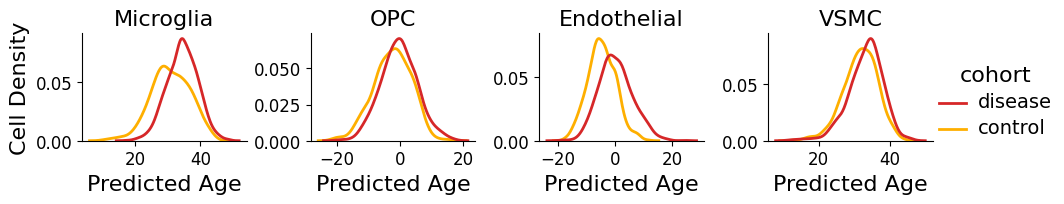

In [16]:
# TOP 4 SUBSET (13 months)

sub_df = df[df["celltype"].isin(["Microglia","OPC","Endothelial","VSMC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

palette = {"control":"#FEAF00", # #935E09
           "disease":"tab:red"}
ncols = 4
g = sns.displot(data=sub_df[sub_df['age']==13], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            linewidth=2, common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/zeng_spatialsmooth_mean_13mo_SUBSET.pdf", bbox_inches='tight')
plt.show()

In [8]:
df_ad = df[df['age']==13]


celltypes = ["Microglia","OPC","Endothelial","VSMC"]
comparisons = [["disease", "control"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_ad[df_ad["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
3.82
1.92
4.76
1.82

DIFF LOWER:
0.69
-1.6
2.93
0.205

DIFF UPPER:
7.87
5.89
6.64
3.55


/local/scratch/edsun/slrmtmp.42835274/ipykernel_88550/3223236532.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


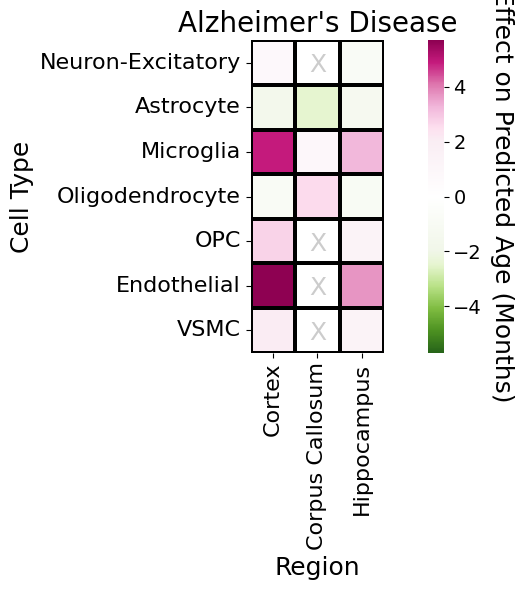

In [18]:
# fingerprint heatmap
effect_cutoff = 0

region_order = ['Cortex', 'Corpus Callosum', 'Hippocampus']

celltypes = pd.unique(df["celltype"]).sort_values()
df["region"] = df["region"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region']==reg)&(df['age']==13)].copy()
        if sub_df[sub_df['cohort']=="disease"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="disease"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Alzheimer's Disease", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/clocks/zeng_spatialsmooth_heatmap_medians_REGIONED_13mo_meanimputed.pdf",
            bbox_inches='tight')
plt.show()

### Kukanja et al. (2024) - Multiple Sclerosis (EAE mouse)

In [4]:
adata = sc.read_h5ad("data/kukanja_EAE_MS_2024/ISS_EAE_multiple_sclerosis_processed.h5ad")

In [20]:
adata.X = adata.X.toarray()

In [21]:
# Exclude certain cell types due to SpaGE algorithm instability
unstable_celltypes = ['Astrocyte', 'Endothelial', 'Ependymal', 'Oligodendrocyte', 'T cell', 'VLMC']
sub_adata = adata[~adata.obs.celltype.isin(unstable_celltypes)].copy()

In [22]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(sub_adata, clock_obj_name=name, fill_missing="mean")

DC
Macrophage


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Monocyte
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Pericyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Schw
VC


In [23]:
# transfer predictions from subset
adata.obs["predicted_age"] = np.nan
adata.obs["predicted_age"][~adata.obs.celltype.isin(unstable_celltypes)] = sub_adata.obs.predicted_age

/local/scratch/edsun/slrmtmp.42835274/ipykernel_88550/53659948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["predicted_age"][~adata.obs.celltype.isin(unstable_celltypes)] = sub_adata.obs.predicted_age


In [24]:
# df.to_csv(f"results/clocks/applied/kukanja_ISSMS_spatialsmooth_mean.csv")
# adata.write_h5ad("results/clocks/anndata/kukanja_ISSMS_spatialsmooth_mean.h5ad")

In [9]:
df = pd.read_csv(f"results/clocks/applied/kukanja_ISSMS_spatialsmooth_mean.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.42835274/ipykernel_88550/2526397448.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


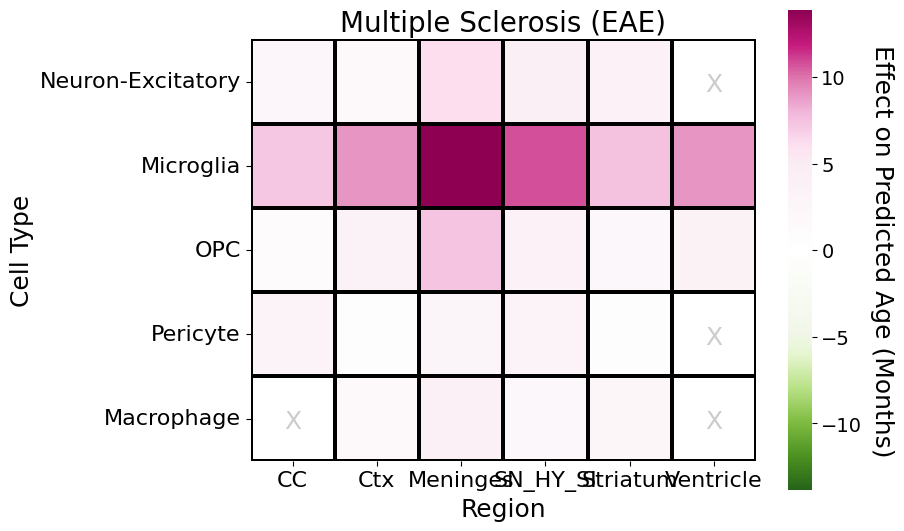

In [27]:
# fingerprint heatmap
effect_cutoff = 0

region_order = ['CC', 'Ctx', 'Meninges', 'SN_HY_SI', 'Striatum', 'Ventricle']
df = df[df["region"].isin(region_order)]
#df["region"] = df["region"].astype(str)

celltypes = pd.unique(df["celltype"]).sort_values()
df["region"] = df["region"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region']==reg)].copy()
        if sub_df[sub_df['cohort']=="EAE"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="EAE"]["pred_age"].median() - sub_df[sub_df['cohort']=="CNTRL"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Multiple Sclerosis (EAE)", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/clocks/kukanja_spatialsmooth_heatmap_medians_REGIONED_meanimputed.pdf",
            bbox_inches='tight')
plt.show()

### Androvic et al. (2023) - Brain Injury MERFISH

In [28]:
adata = sc.read_h5ad("data/androvic_2023_injury_merfish/merfish_injury_processed.h5ad")

In [29]:
# Geometric rotation and labeling of two halves of the brain

def rotate(p, origin=(0, 0), degrees=0):
    
    # rigid rotation by degrees around origin
    
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

rotation_dict = {
    'b2s20':188, 'b3s20':130, 'b4s8':255
}



# --------------------------

new_spatial = adata.obsm['spatial'].copy()
cohorts = adata.obs.cohort.copy().astype(str)

for ii in np.unique(adata.obs["replicate"]):
    sub_adata = adata[adata.obs.replicate==ii]
    
    # center
    sub_adata.obsm["spatial"] = sub_adata.obsm["spatial"]-np.mean(sub_adata.obsm["spatial"],axis=0)
    
    # rotate
    sub_adata.obsm["spatial"] = rotate(sub_adata.obsm["spatial"],
                                      degrees=360-rotation_dict[ii])    
    
    # update coords
    new_spatial[adata.obs.replicate==ii,:] = sub_adata.obsm["spatial"]

adata.obsm["spatial"] = new_spatial
    
# Label cohorts by brain halves
cohorts[adata.obsm["spatial"][:,0]<0] = "Left (Injury)"
cohorts[adata.obsm["spatial"][:,0]>=0] = "Right (Control)"
adata.obs.cohort = cohorts.astype('category')

In [30]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="mean")

Astrocyte
Imputing values for 236 missing genes
Endothelial
Imputing values for 236 missing genes
Ependymal


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 236 missing genes
Macrophage
Imputing values for 236 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 236 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 236 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 236 missing genes
OPC
Imputing values for 236 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 236 missing genes
Other
Pericyte
Imputing values for 236 missing genes
T cell
Imputing values for 236 missing genes
VLMC
Imputing values for 236 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 236 missing genes
doublet


In [31]:
# df.to_csv(f"results/clocks/applied/androvic_injuryMERFISH_spatialsmooth_mean.csv")
# adata.write_h5ad("results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_mean.h5ad")

In [32]:
adata = sc.read_h5ad("results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_mean.h5ad")

In [33]:
# Compute age acceleration and get positive component

from ageaccel_proximity import get_age_acceleration

get_age_acceleration (adata)
adata.obs["positive_age_acceleration"] = [x if x>0 else 0 for x in adata.obs.normalized_age_acceleration]

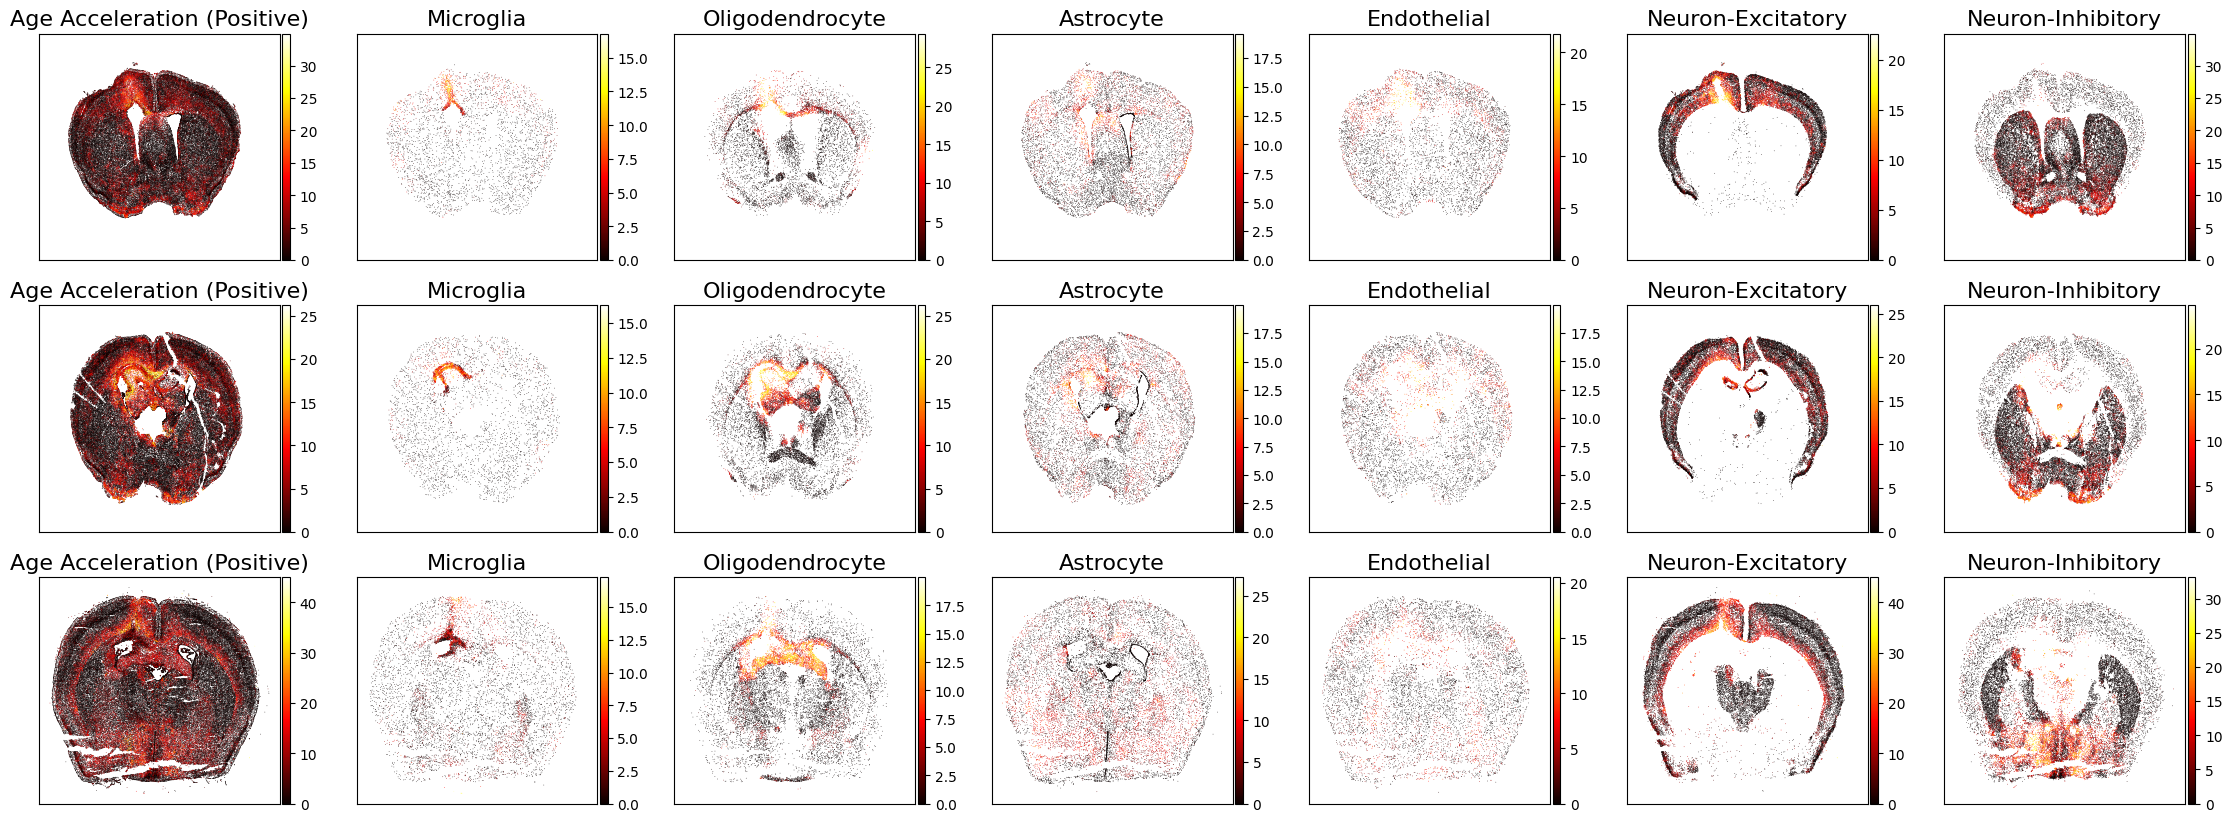

In [34]:
# Spatial Plotting

sc._settings.settings._vector_friendly=True

show_celltypes = ["Microglia", "Oligodendrocyte", "Astrocyte",
                  "Endothelial", "Neuron-Excitatory", "Neuron-Inhibitory"]

nrows = 3
ncols = len(show_celltypes)+1

fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols,10), sharex=True, sharey=True)

for i in range(nrows):
    
    sub_adata = adata[adata.obs.replicate==np.unique(adata.obs.replicate)[i]]
    
    for j in range(ncols):
        
        # make plot with all cells
        if j == 0:
            sc.pl.embedding(sub_adata, "spatial",
                            color="positive_age_acceleration",
                            cmap="hot", size=1,
                            ax = axs[i,j], show=False)
            
            axs[i,j].set_title("Age Acceleration (Positive)", fontsize=16)
        
        # make plot by cell type
        else:
            sc.pl.embedding(sub_adata[sub_adata.obs.celltype==show_celltypes[j-1]], "spatial",
                            color="positive_age_acceleration",
                            cmap="hot", size=1,
                            ax = axs[i,j], show=False)
            
            axs[i,j].set_title(show_celltypes[j-1], fontsize=16)
            
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        
plt.savefig("plots/clocks/spatial_positive_ageaccel_androvic_injury_paneled_meanimputed.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Single-nuclei RNAseq (Allen et al. 2022)

In [4]:
adata = sc.read_h5ad("data/allen_2022_aging_merfish/snRNAseq_processed.h5ad")

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
tadata = sc.read_h5ad(f"results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_Microglia.h5ad")
clock_genes = tadata.var_names.copy()    

# subset into shared genes
intersection = np.intersect1d(clock_genes, adata.var_names)
adata = adata[:,intersection].copy()

In [6]:
import gc
del tadata
gc.collect()

35896

In [7]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, smooth=False, pseudobulk_data=True, add_in_place=False,
                     normalize=False, standardize=False, fill_missing="mean")

Astrocyte
Imputing values for 5 missing genes
Endothelial
Imputing values for 5 missing genes
Macrophage
Imputing values for 5 missing genes
Microglia
Imputing values for 5 missing genes
Neuron-Excitatory
Imputing values for 5 missing genes
Neuron-Inhibitory
Imputing values for 5 missing genes
Neuron-MSN
Imputing values for 5 missing genes
OPC
Imputing values for 5 missing genes
Oligodendrocyte
Imputing values for 5 missing genes
Pericyte
Imputing values for 5 missing genes
T cell
Imputing values for 5 missing genes
VLMC
Imputing values for 5 missing genes
other


In [8]:
df.to_csv(f"results/clocks/applied/allen_snRNAseq_aging_spatialsmooth_mean.csv")
adata.write_h5ad("results/clocks/anndata/allen_snRNAseq_aging_spatialsmooth_mean.h5ad")

In [10]:
df = pd.read_csv(f"results/clocks/applied/allen_snRNAseq_aging_spatialsmooth_mean.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

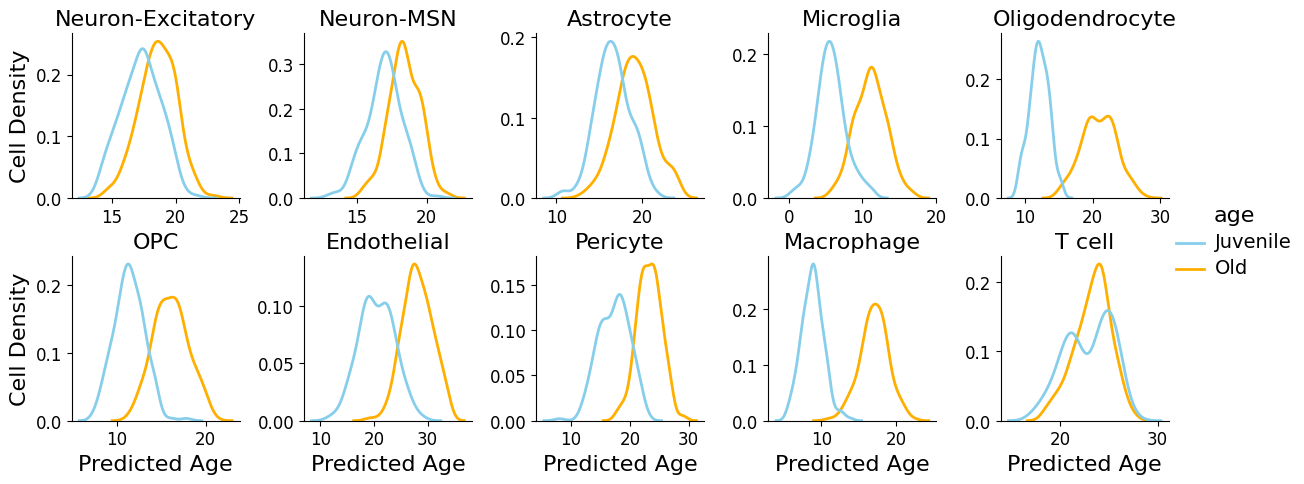

In [10]:
palette = {"Juvenile":"#87CEEB",
           "Old":"#FEAF00"}

df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Juvenile", "Old"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/allen_snRNAseq_aging_spatialsmooth_mean.pdf", bbox_inches='tight')
plt.show()

In [11]:
celltypes = ['Neuron-Excitatory',
 'Neuron-MSN',
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Endothelial',
 'Pericyte',
 'Macrophage',
 'T cell']
comparisons = [[20.93, 0.93]]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
1.22
1.34
2.61
5.5
8.85
4.71
7.43
5.63
8.25
0.143

DIFF LOWER:
1.06
0.854
2.06
4.96
7.02
3.56
4.4
3.46
7.44
-2.74

DIFF UPPER:
1.57
1.81
3.05
6.0
10.6
5.77
10.7
8.87
9.21
3.46


## Single-cell RNAseq (Ximerakis et al. 2019)

In [12]:
adata = sc.read_h5ad("data/external_RNAseq/ximerakis_2019_scRNAseq/scRNAseq_aging_processed.h5ad")

In [13]:
tadata = sc.read_h5ad(f"results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_Microglia.h5ad")
clock_genes = tadata.var_names.copy()    

# subset into shared genes
intersection = np.intersect1d(clock_genes, adata.var_names)
adata = adata[:,intersection].copy()

In [14]:
import gc
del tadata
gc.collect()

3829

In [15]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, smooth=False, pseudobulk_data=True, add_in_place=False,
                     normalize=False, standardize=False, fill_missing="mean")

ABC
ARP
Astrocyte
Imputing values for 36 missing genes
CPC
DC
Ependymal
Imputing values for 36 missing genes
ExcludePerfusion
Hb_VC
MNC
Macrophage
Imputing values for 36 missing genes
Microglia
Imputing values for 36 missing genes
NEUR_immature
NEUR_mature
NSC
Imputing values for 36 missing genes
NendC
Neuroblast
Imputing values for 36 missing genes
Neutrophil
Imputing values for 36 missing genes
OEG
OPC
Imputing values for 36 missing genes
Oligodendrocyte
Imputing values for 36 missing genes
TNC


In [16]:
df.to_csv(f"results/clocks/applied/ximerakis_scRNAseq_aging_spatialsmooth_mean.csv")
adata.write_h5ad("results/clocks/anndata/ximerakis_scRNAseq_aging_spatialsmooth_mean.h5ad")

In [12]:
df = pd.read_csv(f"results/clocks/applied/ximerakis_scRNAseq_aging_spatialsmooth_mean.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

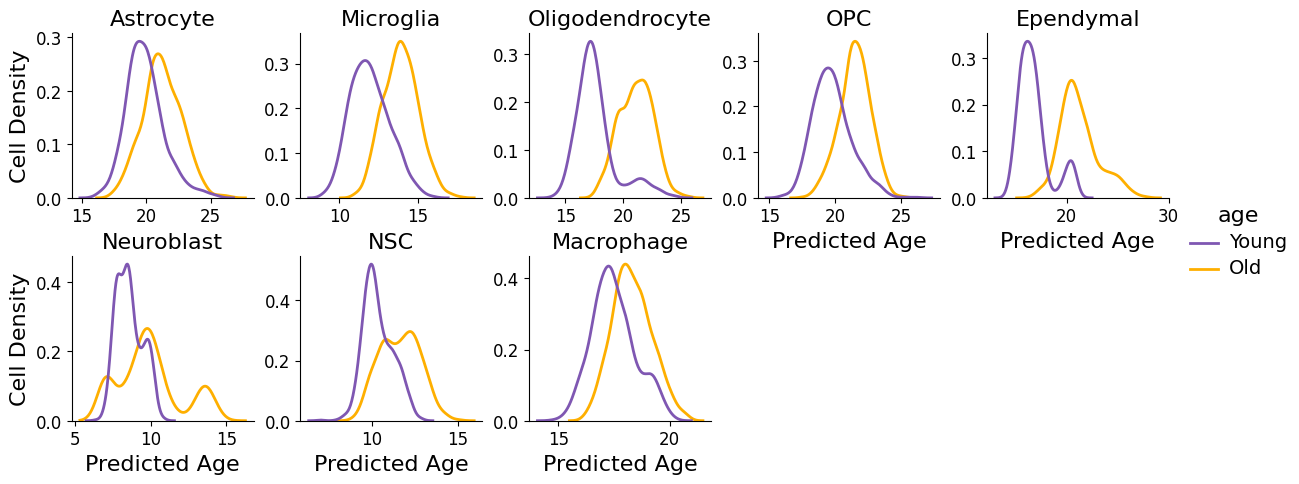

In [18]:
palette = {"Young":"#7F57B2",
           "Old":"#FEAF00"}

df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'2-3mo':'Young','21-22mo':'Old'}[x] for x in df_aging['age']]

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=12/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Young", "Old"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/ximerakis_scRNAseq_aging_spatialsmooth_mean.pdf", bbox_inches='tight')
plt.show()

In [13]:
celltypes = [
 'Astrocyte',
 'Microglia',
 'Oligodendrocyte',
 'OPC',
 'Ependymal',
 'Neuroblast',
 'NSC',
 'Macrophage']
comparisons = [['21-22mo', '2-3mo']]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
1.39
2.04
3.84
1.92
4.45
1.2
1.47
0.859

DIFF LOWER:
0.58
1.18
2.74
0.886
3.31
-1.13
0.281
0.109

DIFF UPPER:
2.16
2.75
4.6
2.55
5.95
4.05
2.24
1.53
